In [16]:
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torch.utils.data import random_split

from torch.optim import AdamW
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from transformers import Trainer, TrainingArguments
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from transformers import get_scheduler
from PIL import Image
from transformers import ViTImageProcessor, ViTModel

In [17]:
class MuseumDataset(torch.utils.data.Dataset):
    """Датасет с фотками музея."""
    def __init__(self, csv_file, root_dir, transform=None):
        super(MuseumDataset, self).__init__()
        self.museum_items = pd.read_csv(csv_file, sep = ';', encoding = 'utf-8')
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = self.museum_items['group'].unique()
        
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = os.path.join(self.root_dir, 
                                str(self.museum_items.iloc[idx, 0]), self.museum_items.iloc[idx, 4])

        image = Image.open(img_file)
        items = self.museum_items.iloc[idx, 3]
        if image.mode != "RGB":
            image = image.convert(mode="RGB")
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'class': items}
        
        class_idx = np.where(self.class_names == sample['class'])[0][0]
        class_name = torch.tensor(class_idx)

        return sample['image'], class_name


    def __len__(self):
        return len(self.museum_items)


torch.Size([3, 224, 224]) tensor(0)
['Археология' 'Оружие' 'Прочие' 'Нумизматика' 'Фото, негативы'
 'Редкие книги' 'Документы' 'Печатная продукция' 'ДПИ' 'Скульптура'
 'Графика' 'Техника' 'Живопись' 'Естественнонауч.коллекция' 'Минералогия']


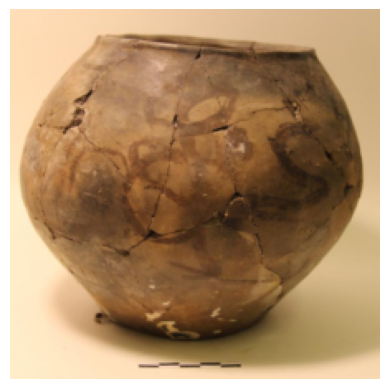

In [18]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),  # изменение размера изображения на 224x224 пикселей
    transforms.ToTensor(),
    
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


df_train = MuseumDataset("train_dataset_mincult-train/train.csv", os.path.join(os.getcwd(), "train_dataset_mincult-train", "train"), trans)
train_dataloader = DataLoader(df_train, batch_size=8,
                        shuffle=True, num_workers=0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)
print(df_train.class_names)
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.axis(False);

In [3]:
class MyViTWithMLP(nn.Module):
    def __init__(self, vit_model, num_classes=15):
        super(MyViTWithMLP, self).__init__()
        self.vit_model = vit_model
        self.hidden_size = vit_model.config.hidden_size
        self.mlp_head = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.vit_model(x)
        output = self.mlp_head(features.last_hidden_state[:, 0])
        return output

In [19]:

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for batch_idx, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)

    inputs = processor(images=images, return_tensors="pt").to(device)

    
    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [20]:
print(len(train_dataloader))

2544


In [21]:
print(last_hidden_states[:10])
torch.save(last_hidden_states, 'last_hidden_states3.pt')
model.save_pretrained('vit3')


tensor([[[ 0.2005,  0.0967, -0.2408,  ...,  0.0088,  0.0133,  0.0997],
         [ 0.3328,  0.0851, -0.2057,  ...,  0.0066,  0.0581,  0.1520],
         [ 0.4062,  0.1522, -0.0669,  ..., -0.0007,  0.1239,  0.1743],
         ...,
         [ 0.3490,  0.1109, -0.2821,  ...,  0.0230,  0.1510,  0.0927],
         [ 0.3171,  0.1043, -0.2990,  ...,  0.0120,  0.1407,  0.0710],
         [ 0.2571,  0.1365, -0.2990,  ...,  0.0828,  0.0597,  0.0677]]],
       device='cuda:0')


In [25]:
classifier = MyViTWithMLP(model, num_classes=15).to(device)

print(classifier.hidden_size)
num_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(classifier.parameters(), lr=5e-5)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        images, labels = batch
        labels = torch.tensor(labels).to(device)

        images = images.to(device)

        outputs = classifier(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_dataloader)}")


768


  0%|          | 0/2544 [00:00<?, ?it/s]

C:\Users\kapit\AppData\Local\Temp\ipykernel_3492\387399247.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch 1/3, Loss: 0.7323079186926579


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch 2/3, Loss: 0.32095975476337607


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch 3/3, Loss: 0.18684027130688458


In [26]:
torch.save(classifier.state_dict(), 'classifier.pth')

torch.Size([3, 224, 224]) tensor(10)
['Археология' 'Оружие' 'Прочие' 'Нумизматика' 'Фото, негативы'
 'Редкие книги' 'Документы' 'Печатная продукция' 'ДПИ' 'Скульптура'
 'Графика' 'Техника' 'Живопись' 'Естественнонауч.коллекция' 'Минералогия']


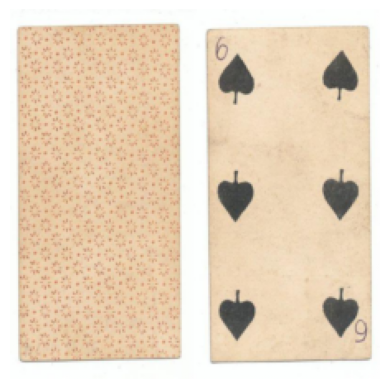

In [4]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),  # изменение размера изображения на 224x224 пикселей
    transforms.ToTensor(),
    
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


df_train = MuseumDataset("train_dataset_mincult-train/train.csv", os.path.join(os.getcwd(), "train_dataset_mincult-train", "train"), trans)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_size = int(0.8 * len(df_train))  
test_size = len(df_train) - train_size  

train_dataset, test_dataset = random_split(df_train, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


image_batch, label_batch = next(iter(train_dataloader))


image, label = image_batch[0], label_batch[0]


print(image.shape, label)
print(df_train.class_names)
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.axis(False);



In [15]:
last_hidden_states = torch.load('last_hidden_states.pt')

classifier2 = MyViTWithMLP(model, num_classes=15)



RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "weight". 

In [6]:
num_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(classifier2.parameters(), lr=5e-5)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        images, labels = batch
        labels = torch.tensor(labels).to(device)

        images = images.to(device)

        outputs = classifier2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_dataloader)}")

NameError: name 'model' is not defined

In [ ]:
torch.save(classifier.state_dict(), 'classifier2.pth')